Goal: create circular maps

In [1]:
import osmnx as ox
import geopandas as gpd
import contextily as cx
import shapely as shp
import matplotlib.pyplot as plt

In [2]:
# PLACE_NAMES = [
#     # "Marikina, Metro Manila",
#     # "Quezon City, Metro Manila",
#     # "Manila, Metro Manila",
#     "Pasig, Metro Manila",
#     # "Taguig, Metro Manila"
# ]

([], [])

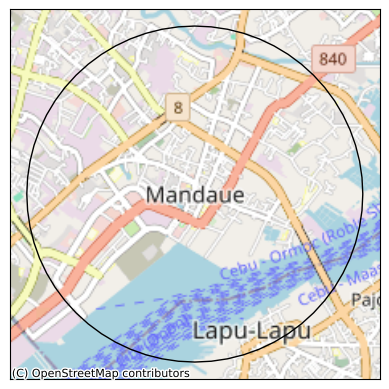

In [3]:
# Set name for Nominatim query
query = "Mandaue"
buffer_dist = 2_000

# Get buffer with aforementioned parameters using custom function
from urban_indicators_scripts import get_buffer_from_place

buffer = get_buffer_from_place(query, buffer_dist)

# Check if buffer location is correct
ax = buffer.to_crs("EPSG:3857").plot(
    facecolor="none"
)
cx.add_basemap(ax=ax, zoom=13, source=cx.providers.OpenStreetMap.Mapnik)
plt.xticks([])
plt.yticks([])

In [4]:
# Get road network within buffer
graph = ox.graph_from_polygon(buffer.geometry[0])

# Convert intersections and streets to geodataframe
intersections, streets = ox.graph_to_gdfs(graph)

In [5]:
# Reproject both GDFs to pseudo-mercator
streets = streets.to_crs("EPSG:3857")
intersections = intersections.to_crs("EPSG:3857")

In [6]:
# Parse `lanes` column in streets GDF using custom function
from urban_indicators_scripts import parse_street_lanes

streets = parse_street_lanes(streets)

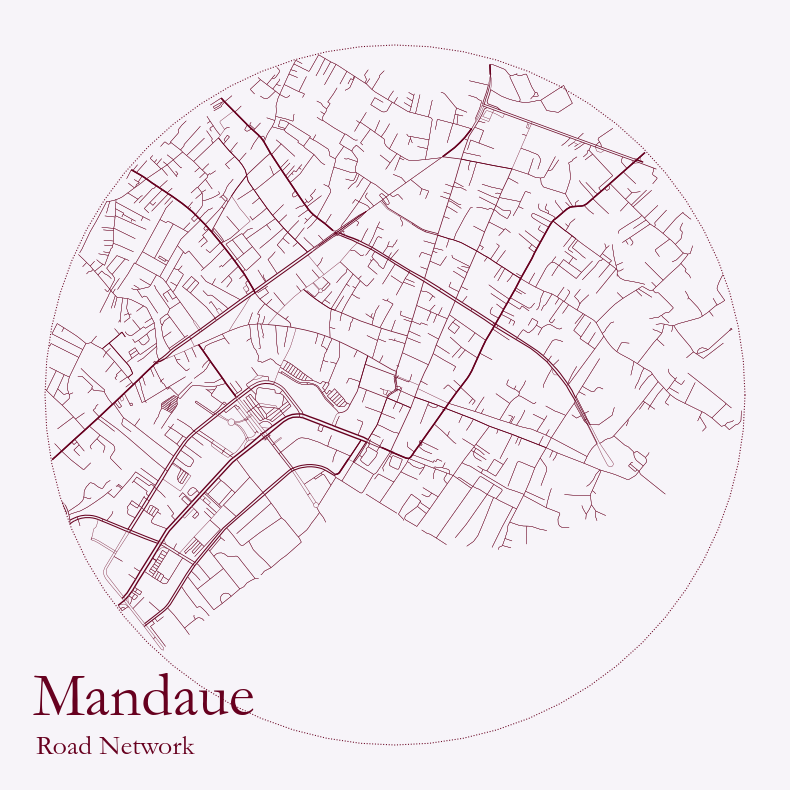

In [16]:
# Plot street network
from urban_indicators_scripts import plot_streets

plot_streets(
    streets,
    buffer,
    color_scheme="PuRd"
)

Ideas for Urban Indicators:
- street density (hexbin/heatmap)
- intersection density (hexbin/heatmap)
- density of x-height buildings (hexbin/heatmap)
- density of x kind of amenity (hexbin/heatmap)
- isochrone from geocoded point